In [4]:
import time
import numpy as np
import os
from scipy.io import wavfile

# sklearn
from sklearn import neighbors
from sklearn.metrics import confusion_matrix

# visualization
import matplotlib.pyplot as plt
import seaborn
from tqdm.notebook import tqdm

# torch
import torch
from torch import nn
import torch.nn.functional as F

# Dataset
from torch.utils.data import DataLoader, Dataset

#Sklearn
from sklearn.model_selection import train_test_split

import copy

from torch.utils.data import random_split

import librosa

In [5]:
sliced_dataset = "short_audio_dataset"
sliced_dataset_lenght = 16050
# sliced_dataset = "shorter_audio_dataset"
# sliced_dataset_lenght = 4013
original_dataset = "audio_dataset"
original_dataset_lenght = 80249

class AudioDataset(Dataset):
    def __init__(self, root_path="./data/", drop_both=False, use_short=False, active='wavs', normalize=False):
        root_folder = root_path + original_dataset if not use_short else root_path + sliced_dataset
        self.max_length = original_dataset_lenght if not use_short else sliced_dataset_lenght
        self.class_map = {"esben" : 0, "peter": 1, "both": 2}
        self.data = []
        self.labels = []
        self.min_val = 10e10
        self.max_val = 0
        self.normalize = normalize
        self.wavs, self.mfccs, self.chromas, self.contrasts, self.centroids, self.bandwidths = [], [], [], [], [], []
        self.wavs_norm, self.mfccs_norm, self.chromas_norm, self.contrasts_norm, self.centroids_norm, self.bandwidths_norm = [], [], [], [], [], []
        
        print("Start reading files")
        for subdir, dirs, files in os.walk(root_folder):
            for file_name in files:
                if drop_both and "both" in subdir:
                   continue
        
                file_path = os.path.join(subdir, file_name)
                self.sample_rate, wav = wavfile.read(file_path)
                wav = wav.astype(np.float32)
                
                if wav.shape[0] > self.max_length:
                    self.max_length = wav.shape[0]
                    print("Found wav with more length than specified max one, new max is:", wav.shape[0])
                
                self.feature_extraction(wav, self.sample_rate)
                wav = np.pad(wav, (0, self.max_length-wav.shape[0]))
                label_str = file_path.split('/')[-3][2:]
                label = (np.int64(self.class_map[label_str]))
                
                self.max_val = np.max(wav) if np.max(wav) > self.max_val else self.max_val
                self.min_val = np.min(wav) if np.min(wav) < self.min_val else self.min_val
                
                self.wavs.append(wav)
                self.labels.append(label)
               
        self.wavs = np.array(self.wavs)
        self.mu  = self.wavs.mean()
        self.std = np.std(self.wavs)
        # self.wavs = torch.Tensor(self.wavs)

        self.active = active
        self.values_dict = {'wavs': 0, 'mfcc': 1, 'chroma': 2, 'contrast': 3}#, 'centroid': 4, 'bandwidth': 5}
        self.values_list = [self.wavs, self.mfccs, self.chromas, self.contrasts] # self.centroids, self.bandwidths]
        self.values_norm_list = []
        for lst in self.values_list:
            self.values_norm_list.append((lst + np.abs(np.min(lst))) / (np.abs(np.min(lst)) + np.max(lst)))
            
        print("="*40)
        print("Loaded DATABASE from {}\n{} total file\nLongest file is {} long\nMean: {}\nStandard deviation: {}\n".
              format(root_folder, len(self.wavs), self.max_length, self.mu, self.std))
        print("="*40)

    def feature_extraction(self, wav, sample_rate):
        self.mfccs.append(np.transpose(np.mean(librosa.feature.mfcc(y=wav, sr=sample_rate, n_mfcc=128).T, axis=0)))
        # self.chromas.append(np.transpose(np.mean(librosa.feature.chroma_cqt(y=wav, sr=sample_rate).T, axis=0)))
        self.chromas.append(np.transpose(np.mean(librosa.feature.chroma_stft(y=wav, sr=sample_rate).T, axis=0)))
        self.contrasts.append(np.transpose(np.mean(librosa.feature.spectral_contrast(y=wav, sr=sample_rate).T, axis=0)))
        self.centroids.append(np.transpose(np.mean(librosa.feature.spectral_centroid(y=wav, sr=sample_rate).T, axis=0)))
        self.bandwidths.append(np.transpose(np.mean(librosa.feature.spectral_bandwidth(y=wav, sr=sample_rate).T, axis=0)))
        
    def __len__(self):
        return len(self.wavs)
    
    def __getitem__(self, idx):
        y = self.labels[idx]
        x = self.values_list[self.values_dict[self.active]][idx]
        if self.normalize:
            x = self.values_norm_list[self.values_dict[self.active]][idx]
        x = torch.Tensor(x)
        return x, y


In [31]:
audio_dataset = AudioDataset(root_path="../data/", drop_both=True, use_short=True)
dataset_len = len(audio_dataset)
train_size, test_size, valid_size = round(dataset_len * 0.7), round(dataset_len * 0.2), round(dataset_len * 0.1)

dataset_train, dataset_test, dataset_valid = torch.utils.data.random_split(audio_dataset, (train_size, test_size, valid_size))


Start reading files
Loaded DATABASE from ../data/short_audio_dataset
1009 total file
Longest file is 16050 long
Mean: -0.6928578019142151
Standard deviation: 2321.9658203125



## Loader

In [7]:
kwargs = {'batch_size': 1, 'num_workers': 8}
loader_train = torch.utils.data.DataLoader(dataset_train, **kwargs, shuffle=True)
loader_test = torch.utils.data.DataLoader(dataset_test, **kwargs, shuffle=True)
loader_valid = torch.utils.data.DataLoader(dataset_valid, **kwargs, shuffle=True)

## Visualize


torch.Size([1, 12])
tensor([[0.2103, 0.3565, 0.6902, 0.7584, 0.4587, 0.4375, 0.4260, 0.3288, 0.2925,
         0.3139, 0.3600, 0.2343]])


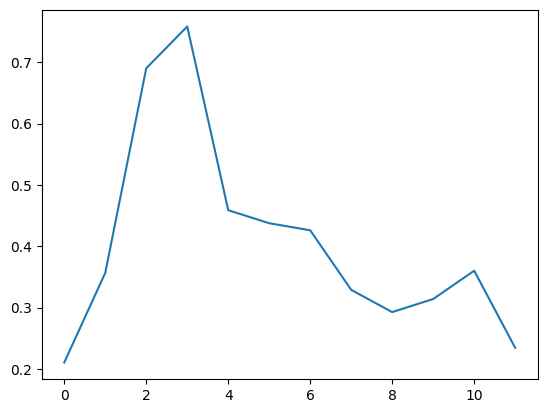

In [8]:
audio_dataset.active = 'chroma'
audio_dataset.normalize = True

for x, y in loader_test:
    print(x.shape)
    print(x)
    plt.plot(np.arange(x.shape[1]), x.flatten())
    plt.show()
    break

# Challenge
* Build a Multi Layer Perceptron, MLP, with one ReLU-activated hidden layer.
* Use the validation set to inform e.g. number of hidden neurons.
* When you're satisfied, then, use the test set to get an  
unbiased estimate of your models performance on the real data distribution.

## Model building function

In [32]:
# or, as an nn.Sequential module:
def build_mlp_feat_norm(input_length,n_hidden_neurons: int):
   return nn.Sequential(
       nn.Flatten(start_dim=1),  # (N, d_data)
       nn.Linear(input_length, n_hidden_neurons), nn.ReLU(),
       nn.Linear(n_hidden_neurons, 2)
   )

def build_mlp(input_length, n_hidden_neurons: int, n_layers: int):
    layers = [nn.Flatten(start_dim=1), nn.Linear(input_length, n_hidden_neurons), nn.ReLU()]
    neurons_interval = np.linspace(n_hidden_neurons, 2, n_layers)
    print(neurons_interval)
    
    for i in range(n_layers-1):
        layers.extend([nn.Linear(round(neurons_interval[i]), round(neurons_interval[i+1])), nn.ReLU()])
    
    
    return nn.Sequential(*layers)



#def build_mlp(input_length, n_hidden_neurons: int, n_layers: int):
#    layers = [nn.Flatten(start_dim=1), nn.Linear(input_length, n_hidden_neurons), nn.ReLU()]
#    n_hidden_neurons = n_hidden_neurons // 2
#  
#    #while n_hidden_neurons > 2 :
#    #    layers.extend([nn.Linear(n_hidden_neurons*2, n_hidden_neurons), nn.ReLU()])
#    #    n_hidden_neurons = n_hidden_neurons // 2
#    
#    layers.append(nn.Linear(n_hidden_neurons, 2))
#    
#    return nn.Sequential(*layers)


## Hyperparameters Legenda

In [12]:
all_losses, all_accuracies = {}, {}
best_accuracy = 0
best_model = None

# LIST OF HYPER PARAMETERS THAT WE WANT TO CHANGE
hidden_neurons = [10, 100, 500, 1000]
learning_rates = [0.01, 0.001, 0.0001]
batch_sizes = [1, 8, 32, 128]
n_layers = [2, 4, 6]
print(audio_dataset[0][0].shape[0])

12


## We use this cell to compare the graphs based on the features and normalization, but keeping the h_parmas fixed


In [ ]:
device = torch.device('cuda')
#%env CUDA_LAUNCH_BLOCKING=1

with open('../output/last_MLP/results_short_no_both_MLP.txt', "w") as f:
  for norm in (True, False):
    audio_dataset.normalize = norm
    for feature in ('wavs', 'mfcc', 'chroma', 'contrast'):  
      audio_dataset.active = feature
      for n_hidden_neurons in ([1000]):
        model = build_mlp_feat_norm(int(audio_dataset[0][0].shape[0]), n_hidden_neurons).to(device)
        #model = MLP(n_hidden_neurons).to(device)
        #opt = torch.optim.SGD(model.parameters(), lr=5e-2)
        opt = torch.optim.Adam(model.parameters(), lr=1e-3)
        sched = torch.optim.lr_scheduler.MultiStepLR(opt, (30,))
        train_losses, train_accuracies = [], []
        valid_losses, valid_accuracies = [], []

        for epoch_idx in tqdm(range(50)):
          # train
          epoch_losses = []
          correct, total = 0, 0
          for x, y in loader_train:
            opt.zero_grad()
            x, y = x.to(device), y.to(device)
            logits = model(x)  # logits: common name for the output before softmax activation
            log_probs = F.log_softmax(logits, dim=1)  # numerically stable version of log(softmax(logits))
            loss = F.nll_loss(log_probs, y)  # negative log likelihood loss
            # or just: loss = F.cross_entropy(logits, y)

            loss.backward()
            opt.step()

            epoch_losses.append(loss.item())
            total += len(x)
            correct += (torch.argmax(logits, dim=1) == y).sum().item()
          train_losses.append(np.mean(epoch_losses))
          train_accuracies.append(correct / total)
# Valid
          epoch_losses = []
          correct, total = 0, 0
          for x, y in loader_valid:
            x, y = x.to(device), y.to(device)
            # Performance tip: we don't want to update weights
            # based on the validation set, so we don't need
            # pytorch to keep track of gradients here
            with torch.no_grad():
              logits = model(x)
            loss = F.cross_entropy(logits, y)

            epoch_losses.append(loss.item())
            total += len(x)
            correct += (torch.argmax(logits, dim=1) == y).sum().item()
          valid_losses.append(np.mean(epoch_losses))
          valid_accuracy = correct / total
          valid_accuracies.append(valid_accuracy)
          sched.step()
          
          if valid_accuracy > best_accuracy:
            best_accuracy = valid_accuracy
            best_model = copy.deepcopy(model), n_hidden_neurons, epoch_idx

        all_losses[n_hidden_neurons] = train_losses, valid_losses
        all_accuracies[n_hidden_neurons] = train_accuracies, valid_accuracies
# Test
        correct, total = 0, 0
        for x, y in loader_test:
          x, y = x.to(device), y.to(device)
          with torch.no_grad():
            logits = model(x)
          total += len(x)
          correct += (torch.argmax(logits, dim=1) == y).sum().item()
# Print to File
        f.writelines(f"Norm: {norm}, Feature: {feature}\n")
        f.writelines(f"Train loss: {train_losses}\nTrain accuracy: {train_accuracies}\n")
        f.writelines(f"Valid loss: {valid_losses}\nValid accuracy: {valid_accuracies}\n")
        f.writelines(f"Test accuracy: {correct / total}\n")

## Big cycle for hyperparameters

In [ ]:
device = torch.device('cuda')
with open('../output/last_MLP/results_short_hyp_MLP.txt', "w") as f:
  audio_dataset.normalize = False
  audio_dataset.active = "mfcc"
  for n_hidden_neurons in hidden_neurons:
    for layers in n_layers:
      for lr in learning_rates:
        for batch_size in batch_sizes:
          kwargs = {'batch_size': batch_size, 'num_workers': 8}
          loader_train = torch.utils.data.DataLoader(dataset_train, **kwargs, shuffle=True)
          loader_test = torch.utils.data.DataLoader(dataset_test, **kwargs, shuffle=True)
          loader_valid = torch.utils.data.DataLoader(dataset_valid, **kwargs, shuffle=True)
          model = build_mlp(int(audio_dataset[0][0].shape[0]), n_hidden_neurons, layers).to(device)
          #model = MLP(n_hidden_neurons).to(device)
          #opt = torch.optim.SGD(model.parameters(), lr=5e-2)
          opt = torch.optim.Adam(model.parameters(), lr=lr)
          sched = torch.optim.lr_scheduler.MultiStepLR(opt, (30,))
          train_losses, train_accuracies = [], []
          valid_losses, valid_accuracies = [], []

          for epoch_idx in tqdm(range(50)):
            # train
            epoch_losses = []
            correct, total = 0, 0
            for x, y in loader_train:
              opt.zero_grad()
              x, y = x.to(device), y.to(device)
              logits = model(x)  # logits: common name for the output before softmax activation
              log_probs = F.log_softmax(logits, dim=1)  # numerically stable version of log(softmax(logits))
              loss = F.nll_loss(log_probs, y)  # negative log likelihood loss
              # or just: loss = F.cross_entropy(logits, y)

              loss.backward()
              opt.step()

              epoch_losses.append(loss.item())
              total += len(x)
              correct += (torch.argmax(logits, dim=1) == y).sum().item()
            train_losses.append(np.mean(epoch_losses))
            train_accuracies.append(correct / total)

# Valid     
            epoch_losses = []
            correct, total = 0, 0
            for x, y in loader_valid:
              x, y = x.to(device), y.to(device)
              # Performance tip: we don't want to update weights
              # based on the validation set, so we don't need
              # pytorch to keep track of gradients here
              with torch.no_grad():
                logits = model(x)
              loss = F.cross_entropy(logits, y)

              epoch_losses.append(loss.item())
              total += len(x)
              correct += (torch.argmax(logits, dim=1) == y).sum().item()
            valid_losses.append(np.mean(epoch_losses))
            valid_accuracy = correct / total
            valid_accuracies.append(valid_accuracy)
            sched.step()

            if valid_accuracy > best_accuracy:
              best_accuracy = valid_accuracy
              best_model = copy.deepcopy(model), n_hidden_neurons, epoch_idx

          all_losses[n_hidden_neurons] = train_losses, valid_losses
          all_accuracies[n_hidden_neurons] = train_accuracies, valid_accuracies
# Test      
          correct, total = 0, 0
          for x, y in loader_test:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
              logits = model(x)
            total += len(x)
            correct += (torch.argmax(logits, dim=1) == y).sum().item()
# Print to File
          f.writelines(f"Norm: {audio_dataset.normalize}, Feature: {audio_dataset.active}\n")
          f.writelines(f"N_layers: {layers}, N_hidden_neurons: {n_hidden_neurons}, LR: {lr}, Batch_size: {batch_size}, Epochs: {50}\n")
          f.writelines(f"Train loss: {train_losses}\nTrain accuracy: {train_accuracies}\n")
          f.writelines(f"Valid loss: {valid_losses}\nValid accuracy: {valid_accuracies}\n")
          f.writelines(f"Test accuracy: {correct / total}\n")
        print("Done batch_size:", batch_size)
      print("Done lr:", lr)
    print("Done layers:", layers)
  print("Done hidden_neurons:", n_hidden_neurons)

In [ ]:
test_acc = {}
with open("../data/mlp_results.txt") as  f:
    lines = f.readlines()
    for i in range(len(lines)):
        line_list = lines[i].split(":")
        if len(line_list) == 3:
            fig = plt.figure(figsize=(8, 4))
            fig.suptitle(lines[i])
            
            train_losses = np.array(lines[i+1].split(':')[1].replace('[', '').replace(']', '').replace(' ', '').replace('\n', '').split(',')).astype(float)
            train_accuracies = np.array(lines[i+2].split(':')[1].replace('[', '').replace(']', '').replace(' ', '').replace('\n', '').split(',')).astype(float)
            valid_losses = np.array(lines[i+3].split(':')[1].replace('[', '').replace(']', '').replace(' ', '').replace('\n', '').split(',')).astype(float)
            valid_accuracies = np.array(lines[i+4].split(':')[1].replace('[', '').replace(']', '').replace(' ', '').replace('\n', '').split(',')).astype(float)
            test_acc[lines[i]] = float(lines[i+5].split(':')[1])
            i += 5

            # ax.set_title("asd")
            # plt.title("lines[i]")
            
            plt.subplot(1, 2, 1)
            plt.xlabel('epoch')
            plt.ylabel('loss')

            p = plt.plot(train_losses, label='train')
            plt.plot(valid_losses, label='valid', ls='--', c=p[0].get_color())
            plt.legend()
            plt.grid()

            plt.subplot(1, 2, 2)
            plt.xlabel('epoch')
            plt.ylabel('accuracy')
            plt.ylim(0, 1)
            
            p = plt.plot(train_accuracies, label='train')
            plt.plot(valid_accuracies, label='valid', ls='--', c=p[0].get_color())
            plt.legend()
            plt.grid()

            plt.tight_layout()
            plt.show()


In [ ]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.xlabel('epoch')
plt.ylabel('loss')
for n, (train_losses, valid_losses) in all_losses.items():
  p = plt.plot(train_losses, label=f'{n}:train')
  plt.plot(valid_losses, label=f'{n}:valid', ls='--', c=p[0].get_color())
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim(0, 1)
for n, (train_accuracies, valid_accuracies) in all_accuracies.items():
  p = plt.plot(train_accuracies, label=f'{n}:train')
  plt.plot(valid_accuracies, label=f'{n}:valid', ls='--', c=p[0].get_color())
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
# test
model, n_hidden_neurons, epoch_idx = best_model
print(f'best val accuracy: {best_accuracy:.2f} with {n_hidden_neurons} hidden neurons after {epoch_idx} epoch')

correct, total = 0, 0
for x, y in loader_valid:
  x, y = x.to(device), y.to(device)
  with torch.no_grad():
    logits = model(x)
  total += len(x)
  correct += (torch.argmax(logits, dim=1) == y).sum().item()
print(f'test accuracy: {correct / total:.2f}')

### A note on overfitting
You may find different interpretations of what overfitting is, including:

* The gap between training loss and validation loss
* When the validation loss starts rising (around epoch 15-20 above)
* The gap between training accuracy and validation accuracy
* When the validation error (here, 1 - accuracy) starts rising (doesn't really happen here, presumably because we're dealing with small models)

In all cases though, it refers to the model learnings something from the training dataset that doesn't generalize to the validation dataset, and we don't really want that.

In lecture 6, we'll look at how to reduce overfitting.

## NOW WE ARE TRAINING AGAIN WITH THE PARAMETERS THAT WE FOUND TO LOOK AT THE LOSS AND CHECK THE CAPACITY AND GENERALIZATION

In [44]:
device = torch.device('cuda')
#%env CUDA_LAUNCH_BLOCKING=1

with open('../output/last_MLP/final_short_MLP_pat.txt', "w") as f:
  audio_dataset.normalize = False
  audio_dataset.active = "mfcc"

  kwargs = {'batch_size': 8, 'num_workers': 8}
  loader_train = torch.utils.data.DataLoader(dataset_train, **kwargs, shuffle=True)
  loader_test = torch.utils.data.DataLoader(dataset_test, **kwargs, shuffle=True)
  loader_valid = torch.utils.data.DataLoader(dataset_valid, **kwargs, shuffle=True)  
  
  for n_hidden_neurons in ([100]):
    model = build_mlp_feat_norm(int(audio_dataset[0][0].shape[0]), n_hidden_neurons).to(device)
    #model = MLP(n_hidden_neurons).to(device)
    #opt = torch.optim.SGD(model.parameters(), lr=5e-2)
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    sched = torch.optim.lr_scheduler.MultiStepLR(opt, (30,))
    train_losses, train_accuracies = [], []
    valid_losses, valid_accuracies = [], []
    
# Early Stopping setup
    patience = 15
    epochs_no_improve = 0
    min_val_loss = np.Inf
    
    for epoch_idx in tqdm(range(50)):
# Train
      epoch_losses = []
      correct, total = 0, 0
      for x, y in loader_train:
        opt.zero_grad()
        x, y = x.to(device), y.to(device)
        logits = model(x)  # logits: common name for the output before softmax activation
        log_probs = F.log_softmax(logits, dim=1)  # numerically stable version of log(softmax(logits))
        loss = F.nll_loss(log_probs, y)  # negative log likelihood loss
        # or just: loss = F.cross_entropy(logits, y)

        loss.backward()
        opt.step()

        epoch_losses.append(loss.item())
        total += len(x)
        correct += (torch.argmax(logits, dim=1) == y).sum().item()
      train_losses.append(np.mean(epoch_losses))
      train_accuracies.append(correct / total)
# Valid
      epoch_losses = []
      correct, total = 0, 0
      for x, y in loader_valid:
        x, y = x.to(device), y.to(device)
        # Performance tip: we don't want to update weights
        # based on the validation set, so we don't need
        # pytorch to keep track of gradients here
        with torch.no_grad():
          logits = model(x)
        loss = F.cross_entropy(logits, y)

        epoch_losses.append(loss.item())
        total += len(x)
        correct += (torch.argmax(logits, dim=1) == y).sum().item()
      valid_losses.append(np.mean(epoch_losses))
      valid_accuracy = correct / total
      valid_accuracies.append(valid_accuracy)
      if np.mean(epoch_losses) < min_val_loss:
        epochs_no_improve = 0
        min_val_loss = np.mean(epoch_losses)
      else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
          print("Early stopping! at epoch: ", epoch_idx)
          break
      sched.step()
      
    all_losses[n_hidden_neurons] = train_losses, valid_losses
    all_accuracies[n_hidden_neurons] = train_accuracies, valid_accuracies
# Test
    correct, total = 0, 0
    for x, y in loader_test:
      x, y = x.to(device), y.to(device)
      with torch.no_grad():
        logits = model(x)
      total += len(x)
      correct += (torch.argmax(logits, dim=1) == y).sum().item()
      
    print("Test accuracy:", correct / total)
# Print to File
    f.writelines(f"Norm: {False}, Feature: mfcc\n")
    f.writelines(f"Train loss: {train_losses}\nTrain accuracy: {train_accuracies}\n")
    f.writelines(f"Valid loss: {valid_losses}\nValid accuracy: {valid_accuracies}\n")
    f.writelines(f"Test accuracy: {correct / total}\n")

  0%|          | 0/50 [00:00<?, ?it/s]

Early stopping! at epoch:  19
Test accuracy: 0.8861386138613861


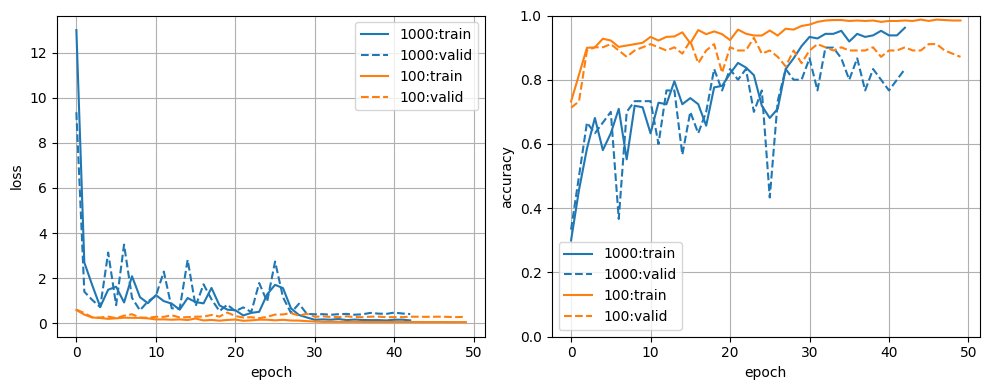

Test accuracy: 0.8166666666666667


<Figure size 640x480 with 0 Axes>

In [28]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.xlabel('epoch')
plt.ylabel('loss')
for n, (train_losses, valid_losses) in all_losses.items():
  p = plt.plot(train_losses, label=f'{n}:train')
  plt.plot(valid_losses, label=f'{n}:valid', ls='--', c=p[0].get_color())
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim(0, 1)
for n, (train_accuracies, valid_accuracies) in all_accuracies.items():
  p = plt.plot(train_accuracies, label=f'{n}:train')
  plt.plot(valid_accuracies, label=f'{n}:valid', ls='--', c=p[0].get_color())
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()
plt.clf()
